Python interpreter will be restarted.
Python interpreter will be restarted.


Running pipeline 3 times with 30s delays...

--- Run 1/3 ---
All data quality checks passed!
Data saved to Delta Lake!
Run 1 completed successfully
Waiting 30 seconds before next run...

--- Run 2/3 ---
All data quality checks passed!
Data saved to Delta Lake!
Run 2 completed successfully
Waiting 30 seconds before next run...

--- Run 3/3 ---
All data quality checks passed!
Data saved to Delta Lake!
Run 3 completed successfully

--- Final Visualization ---
Latest Crypto Prices:


market_cap,price_usd,symbol,timestamp,volume_24h,price_change_24h
1.3793828242797E11,2.35,XRP,2025-05-24T13:59:14.552+0000,2.34788479231E9,-0.83
1.5272735429349E11,1.0,USDT,2025-05-24T13:59:14.552+0000,8.02818177149E10,0.02
6.172233255314E10,1.0,USDC,2025-05-24T13:59:14.552+0000,1.05140511633E10,-0.01
2.580959687327E10,0.27,TRX,2025-05-24T13:59:14.552+0000,6.4460976213E8,1.92
9.14563151967E10,175.78,SOL,2025-05-24T13:59:14.552+0000,4.63481323579E9,-2.05
3.074711230627E11,2546.85,ETH,2025-05-24T13:59:14.552+0000,1.593676146354E10,-1.34
3.396690879416E10,0.23,DOGE,2025-05-24T13:59:14.552+0000,1.81980231859E9,-3.66
2.15701277331452E12,108560.59,BTC,2025-05-24T13:59:14.552+0000,5.502583541231E10,-1.03
9.477697679003E10,672.71,BNB,2025-05-24T13:59:14.552+0000,1.67197047703E9,0.34
2.675657641355E10,0.76,ADA,2025-05-24T13:59:14.552+0000,8.370290623E8,-3.55


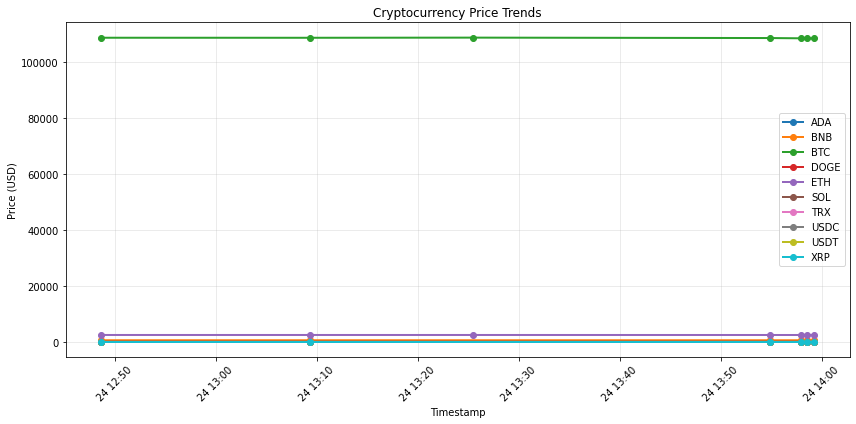

In [0]:
#1. Setup & Configuration

# Install required libraries 
%pip install requests matplotlib

# Import libraries
import requests
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import time

# Configuration 
API_KEY = "ef592ffa-f915-4d43-bdf6-6755b3ffdbef"  
CRYPTO_SYMBOLS = "BTC,ETH,USDT,XRP,BNB,SOL,USDC,DOGE,ADA,TRX"
SAVE_PATH_RAW = "/FileStore/crypto/raw_data"     
SAVE_PATH_PROCESSED = "/FileStore/crypto/processed_data"

#2. Data Ingestion

def fetch_crypto_data():
    """Fetch live data from CoinMarketCap API"""
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest"
    headers = {"X-CMC_PRO_API_KEY": API_KEY}
    params = {"symbol": CRYPTO_SYMBOLS, "convert": "USD"}
    
    try:
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"API Error: {e}")
        return None

#3. Data Transformation

def process_data(raw_data):
    """Clean and transform raw data"""
    spark = SparkSession.builder.getOrCreate()
    
    # Create DataFrame from raw data
    records = []
    for symbol in raw_data["data"]:
        coin = raw_data["data"][symbol]
        records.append({
            "symbol": symbol,
            "timestamp": datetime.now().isoformat(),
            "price_usd": coin["quote"]["USD"]["price"],
            "volume_24h": coin["quote"]["USD"]["volume_24h"],
            "market_cap": coin["quote"]["USD"]["market_cap"],
            # Get 24h change directly from API
            "price_change_24h": coin["quote"]["USD"]["percent_change_24h"]
        })
    
    df = spark.createDataFrame(records)
    
    # Data Cleaning
    df = (df
          .withColumn("timestamp", F.to_timestamp("timestamp"))
          .withColumn("price_usd", F.round("price_usd", 2))
          .withColumn("volume_24h", F.round("volume_24h", 2))
          .withColumn("market_cap", F.round("market_cap", 2))
          .withColumn("price_change_24h", F.round("price_change_24h", 2))
         )
    
    return df

#4. Data Quality Checks

def validate_data(df):
    """Run data quality assertions"""
    # Check for null values in critical columns
    assert df.filter(F.col("price_usd").isNull()).count() == 0, "Null values in price!"
    
    # Check schema
    expected_cols = {"symbol", "timestamp", "price_usd", "volume_24h", "market_cap", "price_change_24h"}
    assert set(df.columns) == expected_cols, "Schema mismatch!"
    
    print("All data quality checks passed!")

#5. Save to Delta Lake

def save_data(df, mode="append"):
    """Save data to Delta Lake"""
    # Save raw data 
    df.write.format("delta").mode(mode).save(SAVE_PATH_RAW)
    
    # Save processed data 
    df.write.format("delta").mode("overwrite").save(SAVE_PATH_PROCESSED)
    print("Data saved to Delta Lake!")

#6. Visualization & Analysis

def visualize_data():
    """Generate time-series plot and table"""
    spark = SparkSession.builder.getOrCreate()
    
    try:
        # Read historical raw data for trends
        df_historical = spark.read.format("delta").load(SAVE_PATH_RAW)
        
        # Display latest processed data table
        df_latest = spark.read.format("delta").load(SAVE_PATH_PROCESSED)
        print("Latest Crypto Prices:")
        display(df_latest.orderBy(F.desc("timestamp")))
        
        # Create trendline plot using historical data
        pdf = df_historical.toPandas()
        pdf["timestamp"] = pd.to_datetime(pdf["timestamp"])
        
        if len(pdf) > 1:  
            plt.figure(figsize=(12, 6))
            
            for symbol in pdf["symbol"].unique():
                symbol_data = pdf[pdf["symbol"] == symbol].sort_values("timestamp")
                if len(symbol_data) > 1:  
                    plt.plot(symbol_data["timestamp"], symbol_data["price_usd"], 
                            marker='o', label=symbol, linewidth=2)
            
            plt.title("Cryptocurrency Price Trends")
            plt.xlabel("Timestamp")
            plt.ylabel("Price (USD)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            display(plt.show())
        else:
            print("Not enough historical data for trend visualization. Run the pipeline multiple times to build history.")
            
    except Exception as e:
        print(f"Visualization error: {e}")

#7. Orchestration with Multiple Runs

def run_pipeline_once():
    """Run the pipeline once"""
    raw_data = fetch_crypto_data()
    
    if raw_data:
        processed_df = process_data(raw_data)
        validate_data(processed_df)
        save_data(processed_df)
        return True
    else:
        print("Pipeline failed at ingestion step!")
        return False

def run_pipeline_multiple_times(num_runs=5, delay_seconds=60):
    """Run pipeline multiple times to build historical data"""
    print(f"Running pipeline {num_runs} times with {delay_seconds}s delays...")
    
    for i in range(num_runs):
        print(f"\n--- Run {i+1}/{num_runs} ---")
        success = run_pipeline_once()
        
        if success:
            print(f"Run {i+1} completed successfully")
            if i < num_runs - 1:  # Don't wait after the last run
                print(f"Waiting {delay_seconds} seconds before next run...")
                time.sleep(delay_seconds)
        else:
            print(f"Run {i+1} failed")
            break
    
    print("\n--- Final Visualization ---")
    visualize_data()

#Multiple runs to build historical data 
run_pipeline_multiple_times(num_runs=3, delay_seconds=30)